In [1]:
from google.colab import drive
drive.mount("/content/MyDrive/")

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity # 코사인유사도

**아이템기반 협업필터링**


---



**데이터 준비**

In [3]:
filename = '/content/MyDrive/MyDrive/codestates/cp2/df_model.csv'  # 고객 분류한 데이터(model_df) 불러오기
df_model = pd.read_csv(filename)
df_model.head()

,Unnamed: 0,user_id,product_id,event_type,count
0,31964969,33869381,7002639,view,1
1,15808538,64078358,10600284,view,1
2,2420043,183503497,22200103,view,1
3,4800257,184265397,6902133,view,1
4,20219228,184265397,27400002,view,1


In [4]:
df_model.drop(['Unnamed: 0'], axis = 1, inplace = True) # Unnamed 삭제
df_model.head()

,user_id,product_id,event_type,count
0,33869381,7002639,view,1
1,64078358,10600284,view,1
2,183503497,22200103,view,1
3,184265397,6902133,view,1
4,184265397,27400002,view,1


In [14]:
df_model['event_type'].value_counts()

view        40779399
cart          926516
purchase      742849
Name: event_type, dtype: int64

In [23]:
df_model['event_type'].count()

42448764

([<matplotlib.patches.Wedge at 0x7f86731ce810>,
 [Text(-1.1412342968472802, 0.1417190167179207, 'view'),
  Text(1.1317226083454177, -0.20421541998547563, 'cart'),
  Text(1.1482624979220948, -0.0631920554002737, 'purchase')],
 [Text(-0.6450454721310713, 0.08010205292752039, '96.1%'),
  Text(0.6396693003691492, -0.1154261069483123, '2.2%'),
  Text(0.6490179336081405, -0.035717248704502526, '1.7%')])

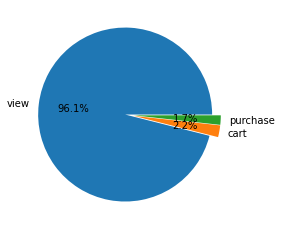

In [26]:
# view, purchase, cart 비율 파이 차트

ratio = [40779399, 926516, 742849] # 
labels = ['view', 'cart', 'purchase']
explode = [0.05, 0.05, 0.05]

plt.pie(ratio, labels = labels,autopct = '%.1f%%', explode = explode) # 96.1%, 2.2%, 1.7%

In [31]:
print(40779399 * 1/400, 926516 * 1/400, 742849 * 1/400) # 축소할 데이터 비율

101948.4975 2316.29 1857.1225


In [5]:
view_model = df_model[df_model['event_type'] == 'view'].head(101948)
cart_model = df_model[df_model['event_type'] == 'cart'].head(2316)
purchase_model = df_model[df_model['event_type'] == 'purchase'].head(1857)

a = pd.concat([view_model,cart_model,purchase_model])
a

,user_id,product_id,event_type,count
0,33869381,7002639,view,1
1,64078358,10600284,view,1
2,183503497,22200103,view,1
3,184265397,6902133,view,1
4,184265397,27400002,view,1
...,...,...,...,...
241533,512375299,23900299,purchase,3
241641,512375312,4803977,purchase,3
241648,512375312,1004249,purchase,3
241718,512375334,3701387,purchase,3


In [6]:
a.drop(['event_type'], axis = 1, inplace = True) # event_type 삭제, 데이터 줄이기

In [7]:
data = a

**train, test 데이터 나누기**

In [8]:
# train ,test 나누기
from sklearn.model_selection import train_test_split

train, test = train_test_split(a, test_size = 0.2, random_state = 0) # 8:2 train , test 나누기 랜덤 스테이트 고정

In [9]:
train # train 데이터 확인

,user_id,product_id,count
25366,445342778,1003592,1
34620,456810531,14100255,1
37684,459687426,17800009,1
27293,448715750,13201191,1
28884,450820761,26401048,1
...,...,...,...
21452,439456817,17700214,1
46399,467449679,38900090,1
43093,463946233,26300507,1
44050,465257068,4200995,1


In [10]:
test['count'].value_counts() # count 비율 확인

1    20378
2      479
3      368
Name: count, dtype: int64

**train 데이터**

In [14]:
ratings_train = train.pivot_table(index='product_id', columns='user_id',values='count') # train 데이터 피봇
ratings_train

user_id,33869381,64078358,183503497,184265397,200673532,205053188,208669541,209714031,210507313,216064734,...,512375136,512375160,512375169,512375243,512375245,512375263,512375293,512375299,512375312,512375334
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58300001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58300008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
ratings_train = ratings_train.fillna(0) # 결측치 0으로
ratings_train

user_id,33869381,64078358,183503497,184265397,200673532,205053188,208669541,209714031,210507313,216064734,...,512375136,512375160,512375169,512375243,512375245,512375263,512375293,512375299,512375312,512375334
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58300001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58300008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
item_based_collabor_train = cosine_similarity(ratings_train) # 코사인유사도 구하기
item_based_collabor_train

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.70710678,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.70710678, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [18]:
# 아이템 별 서로 유사한 정도(자신과 일치하는 값은 1)
item_based_collabor_train = pd.DataFrame(data = item_based_collabor_train, index = ratings_train.index, columns = ratings_train.index)
item_based_collabor_train.head()

product_id,1000978,1001588,1002062,1002098,1002099,1002100,1002101,1002102,1002225,1002266,...,56900002,56900004,57000001,57600004,57600031,58000000,58300001,58300008,58300010,60500002
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,1.0,0.000000,0.0,0.000000,0.000000,0.288675,0.115470,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,1.000000,0.0,0.000000,0.077152,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002062,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002098,0.0,0.000000,0.0,1.000000,0.125988,0.204124,0.163299,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002099,0.0,0.077152,0.0,0.125988,1.000000,0.000000,0.185164,0.062994,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# 마음에 드는 물건과 유사한 물건 추천
def get_item_based_collabor_train(product_id) :
  return item_based_collabor_train[product_id].sort_values(ascending = False)[:10] # 10개 추천

In [23]:
get_item_based_collabor_train(1002099)

product_id
1002099     1.000000
1002101     0.185164
12201214    0.154303
18000101    0.154303
1004406     0.154303
1004403     0.154303
1306428     0.154303
44500032    0.154303
1306451     0.154303
1307477     0.154303
Name: 1002099, dtype: float64

**test 데이터**

In [24]:
ratings_test = test.pivot_table(index='product_id', columns='user_id',values='count') # 피봇
ratings_test

user_id,184265397,195082191,205053188,208669541,209714031,210507313,219406386,222907508,224520397,228761834,...,512374518,512374626,512374786,512374905,512374930,512374978,512375018,512375019,512375027,512375133
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55600013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55900001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
ratings_test = ratings_test.fillna(0) # 결측치 0으로
ratings_test

user_id,184265397,195082191,205053188,208669541,209714031,210507313,219406386,222907508,224520397,228761834,...,512374518,512374626,512374786,512374905,512374930,512374978,512375018,512375019,512375027,512375133
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55600013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55900001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
item_based_collabor_test = cosine_similarity(ratings_test)
item_based_collabor_test

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.26726124, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.26726124, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [29]:
# 아이템 별 서로 유사한 정도(자신과 일치하는 값은 1)
item_based_collabor_test = pd.DataFrame(data = item_based_collabor_test, index = ratings_test.index, columns = ratings_test.index)
item_based_collabor_test

product_id,1001588,1002098,1002099,1002100,1002101,1002102,1002266,1002396,1002398,1002482,...,54900009,54900020,54900021,54900022,55000008,55000014,55600013,55900001,56900004,58300001
product_id,,,,,,,,,,,,,,,,,,,,,
1001588,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002098,0.0,1.000000,0.267261,0.000000,0.333333,0.707107,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002099,0.0,0.267261,1.000000,0.000000,0.178174,0.377964,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002100,0.0,0.000000,0.000000,1.000000,0.235702,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002101,0.0,0.333333,0.178174,0.235702,1.000000,0.235702,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55000014,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55600013,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
55900001,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
# 마음에 드는 물건과 유사한 물건 추천
def get_item_based_collabor_test(product_id) :
  return item_based_collabor_test[product_id].sort_values(ascending = False)[:10] # 10개 까지 추천

In [30]:
get_item_based_collabor_test(1002101)

product_id
1002101    1.000000
1002546    0.333333
1002098    0.333333
1002100    0.235702
1002102    0.235702
1003363    0.192450
1005128    0.192450
1002099    0.178174
1004888    0.117851
1003285    0.105409
Name: 1002101, dtype: float64

**평가지표**